In [1]:
from numpy.random import seed
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras import Input
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

tensorflow.random.set_seed(2)
np.random.seed(1907)

seed(1907)
tensorflow.random.set_seed(2)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

## Convert TotalCharges to numeric
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')

## Replace yes and No in the Churn column to 1 and 0. 1 for the event and 0 for the censured data.
df['Churn']=df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0 )

## Impute the null value with the median value

df.TotalCharges.fillna(value=df['TotalCharges'].median(),inplace=True)
df= df.drop('customerID', axis = 1)

df = pd.get_dummies(df)
print("The data size:", df.shape)

labels = np.array(df['TotalCharges'])
labelsChurn = np.array(df['Churn'])
df= df.drop('TotalCharges', axis = 1)
df= df.drop('MonthlyCharges', axis = 1)
df= df.drop('Churn', axis = 1)

train_x, test_x, train_y, test_y, trainChurn_y, testChurn_y = train_test_split(df, labels, labelsChurn, test_size = 0.25, shuffle=False)

The data size: (7043, 46)


In [3]:
# created scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(train_x)
# transform training dataset
train_x = scaler.transform(train_x)
# transform test dataset
test_x = scaler.transform(test_x)

In [4]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(train_x.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])

history = model.fit(train_x, train_y, epochs=30, batch_size=32,  verbose=1, validation_split=0.2)

test_mse_score, test_mae_score = model.evaluate(test_x, test_y)

Train on 4225 samples, validate on 1057 samples
Epoch 1/30
4225/4225 [==============================] - 0s 75us/step - loss: 8374696.4315 - mse: 8374697.0000 - val_loss: 3803839.8415 - val_mse: 3803839.5000
Epoch 2/30
4225/4225 [==============================] - 0s 37us/step - loss: 1279199.3395 - mse: 1279199.2500 - val_loss: 768874.7552 - val_mse: 768874.8125
Epoch 3/30
4225/4225 [==============================] - 0s 51us/step - loss: 600248.1269 - mse: 600248.0625 - val_loss: 500797.9693 - val_mse: 500798.0000
Epoch 4/30
4225/4225 [==============================] - 0s 39us/step - loss: 372885.2380 - mse: 372885.2812 - val_loss: 281126.1232 - val_mse: 281126.1562
Epoch 5/30
4225/4225 [==============================] - 0s 44us/step - loss: 186495.9786 - mse: 186496.0156 - val_loss: 132210.1622 - val_mse: 132210.1719
Epoch 6/30
4225/4225 [==============================] - 0s 36us/step - loss: 70528.1193 - mse: 70528.1250 - val_loss: 43888.1491 - val_mse: 43888.1484
Epoch 7/30
4225/4225

In [5]:
test_mse_score

13694.168690774062

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 43)           0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          5632        input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           8256        dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 32)           2080        dense_6[0][0]                    
____________________________________________________________________________________________

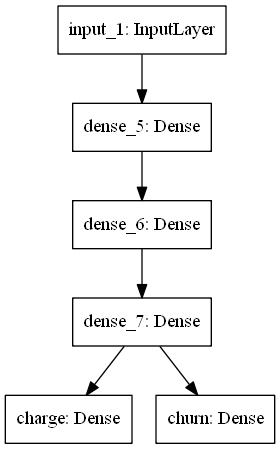

In [6]:
ModelInput = Input(shape=(train_x.shape[1],))

ModelLayer = layers.Dense(128, activation='relu')(ModelInput)
ModelLayer = layers.Dense(64, activation='relu')(ModelLayer)
ModelLayer = layers.Dense(32, activation='relu')(ModelLayer)

# prediction output
charge_pred = layers.Dense(1, name='charge')(ModelLayer)
churn_pred = layers.Dense(1, activation='sigmoid',name='churn')(ModelLayer)

model = models.Model(ModelInput, outputs=[charge_pred, churn_pred])

print(model.summary())
plot_model(model, to_file='shared_input_layer.png')

In [7]:
model.compile(optimizer='rmsprop',
loss={'charge': 'mse','churn': 'binary_crossentropy'}, loss_weights=[0.01, 10])


model.fit(train_x, {'charge': train_y, 'churn': trainChurn_y}, epochs=30, batch_size=32)

(nn_pred_test, nn_pred_testChurn)= model.predict(test_x)

nn_pred_testChurnClass = np.round(nn_pred_testChurn)

print ("NN Test Accuracy: ", metrics.accuracy_score(testChurn_y, nn_pred_testChurnClass))
print ("NN Test MSE: ", metrics.mean_squared_error(test_y, nn_pred_test))

Epoch 1/30
5282/5282 [==============================] - 0s 71us/step - loss: 79015.6671 - charge_loss: 7857446.5000 - churn_loss: 0.6238
Epoch 2/30
5282/5282 [==============================] - 0s 43us/step - loss: 9531.3401 - charge_loss: 948231.6875 - churn_loss: 1.4425
Epoch 3/30
5282/5282 [==============================] - 0s 33us/step - loss: 4906.7129 - charge_loss: 487775.8125 - churn_loss: 1.5543
Epoch 4/30
5282/5282 [==============================] - 0s 41us/step - loss: 2514.3753 - charge_loss: 249683.5938 - churn_loss: 1.5378
Epoch 5/30
5282/5282 [==============================] - 0s 40us/step - loss: 869.1289 - charge_loss: 85213.4688 - churn_loss: 1.4882
Epoch 6/30
5282/5282 [==============================] - 0s 42us/step - loss: 395.3050 - charge_loss: 37844.0742 - churn_loss: 1.4901
Epoch 7/30
5282/5282 [==============================] - 0s 43us/step - loss: 318.1067 - charge_loss: 30235.9941 - churn_loss: 1.4966
Epoch 8/30
5282/5282 [==============================] - 0s 